# CUNEF MUCD 2021/2022
## News Classification
Autor:  
- Antonio Tello Gómez

# Preprocessing and Exploratory Data Analysis

In [2]:
#Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Functionalities
from collections import Counter
import os


#NLP
import string
import re
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import spacy
from spacy import displacy

## Load the data

Data loading, simple preprocessing and exploration

In [3]:
df = pd.read_csv('../data/fake_or_real_news.csv', usecols=['title','text','label'])
df["full_text"] = df["title"] +" "+df["text"]
df.drop(['title','text'],axis=1,inplace=True)
df = df[['full_text', 'label']]
df.head()

,full_text,label
0,You Can Smell Hillary’s Fear Daniel Greenfield...,FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,FAKE
2,Kerry to go to Paris in gesture of sympathy U....,REAL
3,Bernie supporters on Twitter erupt in anger ag...,FAKE
4,The Battle of New York: Why This Primary Matte...,REAL


I have created a new column with the full text of the news. 

In [4]:
df.shape

(6335, 2)

There are 6335 labelled news

In [5]:
df.isna().sum()

full_text    0
label        0
dtype: int64

There are not any null values

In [6]:
df.duplicated().sum()

29

There are some duplicates, let´s see them

In [7]:
df[df.full_text.duplicated(keep=False)].sort_values('full_text').head(10)

,full_text,label
3216,An Open Letter to Black South African Police O...,FAKE
4885,An Open Letter to Black South African Police O...,FAKE
25,Anti-Trump forces seek last-ditch delegate rev...,REAL
5536,Anti-Trump forces seek last-ditch delegate rev...,REAL
6083,Biden Blames “Lazy American Women” For The Eco...,FAKE
5943,Biden Blames “Lazy American Women” For The Eco...,FAKE
5417,"Black Agenda Radio for Week of Nov. 7, 2016 Ne...",FAKE
1155,"Black Agenda Radio for Week of Nov. 7, 2016 Ne...",FAKE
2952,"Black Agenda Report for Week of Oct 31, 2016 N...",FAKE
2128,"Black Agenda Report for Week of Oct 31, 2016 N...",FAKE


we can keep any of them, let´s drop the others off

In [8]:
df.drop_duplicates(inplace=True)

## Preprocessing

Preprocessing the data to be ready for the modelling

### Functions to clean text

In [9]:
# Function to remove html tags
def clean_html(text):
    text = re.sub(r'<.*?>', '', text)
    return text

In [10]:
#Function to remove urls
def remove_url(text):
    text = re.sub(r'http\S+', 'url', text)
    return text

In [11]:
# Function to remove /n 
def remove_newline(text):
    text = text.replace('\n', ' ')
    return text

In [12]:
# Function to remove all punctuation
def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

The `translate()` method returns a string where some specified characters are replaced with the character described in a dictionary, or in a mapping table.  
Use the `maketrans()` method to create a mapping table.

In [13]:
# Fuctions to remove literal quotes and other special characters
remove_quotes = lambda x: x.replace('’', '').replace('“', '').replace('”','').replace('‘','').replace(' — ',' ')

In [14]:
#Funtion to clean numbers in text
def clean_numbers(text):
    text = re.sub(r'\d+', '', text)
    return text

### Lemmatization

In [15]:
# Lemmatization
def lemmatizer(text):
    lemmatizer = nltk.WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word,pos='v') for word in text.split()]
    return text

### StopWords

In [16]:
# Stop Words
def stopwords_removal(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = [word for word in text if word not in stop_words]
    text = ' '.join(text)
    return text

### Transformation

In [17]:
def preprocessing(text, remove_number=False):
    #Normalize
    text = text.strip().lower()
    # Clean text
    text = clean_html(text)
    text = remove_url(text)
    text = remove_newline(text)
    text = remove_punctuation(text)
    text = remove_quotes(text)
    if remove_number:
        text = clean_numbers(text)
    # Lemmatization
    text = lemmatizer(text)
    #Removing Stop Words
    text = stopwords_removal(text)
    return text

`strip()` removes empty spaces at the beginning and at the end of the string,  
`lower()` transform everything to lower case. 

In [18]:
df['clean_text'] = df['full_text'].map(lambda x: preprocessing(x))

An example can be found below of both clean text and original text. This way you can check if there are any unwanted characters left. Which is not the case.

In [19]:
df.iloc[3]['clean_text']

'bernie supporters twitter erupt anger dnc try warn kaydee king kaydeeking november 9 2016 lesson tonights dem losses time democrats start listen voters stop run establishment candidates people bernie people4bernie november 9 2016 dems didnt want tight race shouldnt work bernie walker bragman walkerbragman november 9 2016 new york time columnist paul krugman one hillary clintons outspoken surrogates contentious democratic primary blame clintons poor performance green party candidate jill stein far receive negligible number vote nationally say stein ralph nader 2016 prevent clinton victory account berniesteachers throw krugmans analysis back face candidate issue take responsibility url teachers bernie berniesteachers november 9 2016 ana navarro republican recently endorse hillary clinton sum preposterous nature 2016 presidential election tweet gop nominate damn candidate could lose hillary clinton democrats nominate damn candidate could lose trump ana navarro ananavarro november 9 2016 

In [20]:
df.iloc[3]['full_text']

"Bernie supporters on Twitter erupt in anger against the DNC: 'We tried to warn you!' — Kaydee King (@KaydeeKing) November 9, 2016 The lesson from tonight's Dem losses: Time for Democrats to start listening to the voters. Stop running the same establishment candidates. \n— People For Bernie (@People4Bernie) November 9, 2016 If Dems didn't want a tight race they shouldn't have worked against Bernie. \n— Walker Bragman (@WalkerBragman) November 9, 2016 \nNew York Times columnist Paul Krugman, who was one of Hillary Clinton’s most outspoken surrogates during the contentious Democratic primary, blamed Clinton’s poor performance on Green Party candidate Jill Stein, who has so far received a negligible number of votes nationally, saying Stein was the Ralph Nader of 2016 in preventing a Clinton victory. The account @BerniesTeachers threw Krugman’s analysis back in his face. Your candidate was the issue. Take responsibility. https://t.co/KHyOuUSrFS \n— Teachers for Bernie (@BerniesTeachers) No

## Label Transformation

Convert the labels to binary values  
0 = Real  
1 = Fake

In [21]:
df['label'] = df['label'].map({'FAKE': 1, 'REAL': 0})

## Save Processed Data

To use it in the modelling phase.

In [22]:
#Reallocate columns and drop index
df = df[['full_text','clean_text', 'label']]
df.reset_index(drop=True,inplace=True)

In [23]:
#save to csv 
df.to_csv('../data/fake_or_real_news_clean.csv', index=False, encoding='utf-8')

## Load Processed Data

In [35]:
#Load the clean data
df = pd.read_csv('../data/fake_or_real_news_clean.csv')

## Exploratory Data Analysis (EDA)

In [22]:
def plot_word_number_histogram(text):
    text.str.split().map(lambda x: len(x)).plot(kind='hist', bins=50, figsize=(15,5)).set_title('Word Count Histogram')

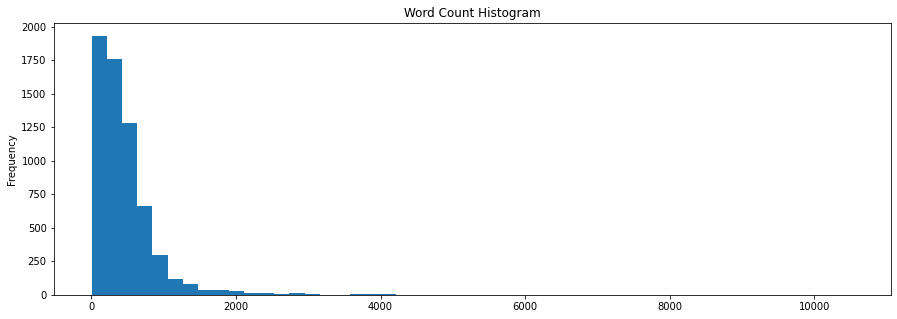

In [23]:
plot_word_number_histogram(df['clean_text'])

This plot shows the number of words per document. As we can see, most of the news have a length of fewer than 2000 words. However, the distribution is highly skewed with news of more than 10000 words.

### Term Frequency Analysis


Exploring frequency of words in the news

In [24]:
real_news = df.clean_text[df.label == 'REAL']
fake_news = df.clean_text[df.label == 'FAKE']

In [25]:
text_real_news = ' '.join(real_news)
text_fake_news = ' '.join(fake_news)
all_text = ' '.join(df.clean_text)

Text(0.5, 1.0, 'Top 30 words in real news')

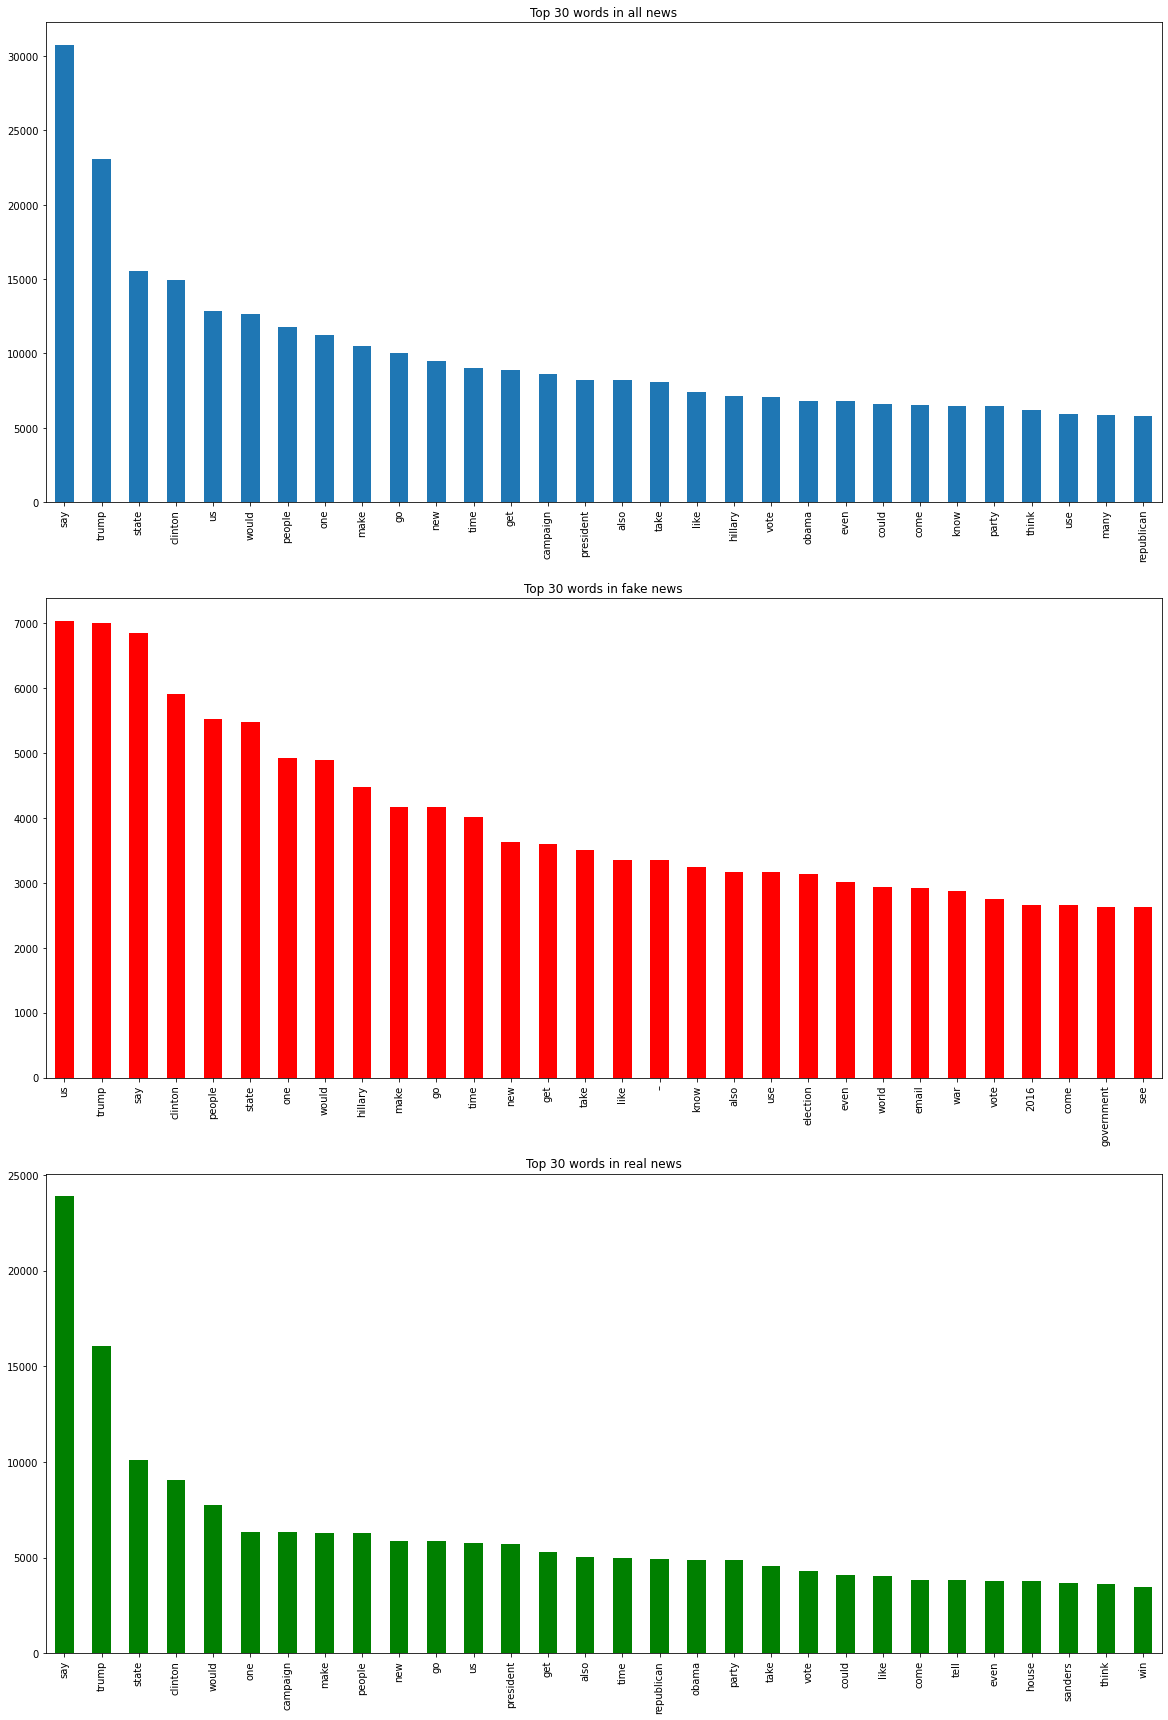

In [26]:
fig, axs = plt.subplots(3,1, figsize=(20,30))

pd.Series(Counter(word_tokenize(all_text))).sort_values(ascending=False).iloc[:30].plot(kind="bar", ax=axs[0]).set_title('Top 30 words in all news')
pd.Series(Counter(word_tokenize(text_fake_news))).sort_values(ascending=False).iloc[:30].plot(kind="bar", color="red",ax=axs[1]).set_title('Top 30 words in fake news')
pd.Series(Counter(word_tokenize(text_real_news))).sort_values(ascending=False).iloc[:30].plot(kind="bar", color="green",ax=axs[2]).set_title('Top 30 words in real news')

#### Word Cloud

Visual representations of words that give greater prominence to words that appear more frequently

In [27]:
def wordcloud_plot(texto, color_fondo, color_palabras):
    wordcloud = WordCloud(width=3000, 
                          height=2000, 
                          random_state=2022, 
                          background_color=color_fondo, 
                          colormap=color_palabras,
                          collocations=False).generate(texto) 
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud) 
    plt.axis("off");
    return wordcloud

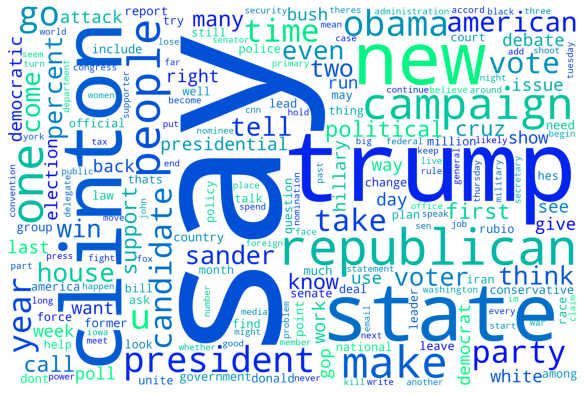

In [28]:
wordcloud_plot(text_real_news, 'white', 'winter_r')

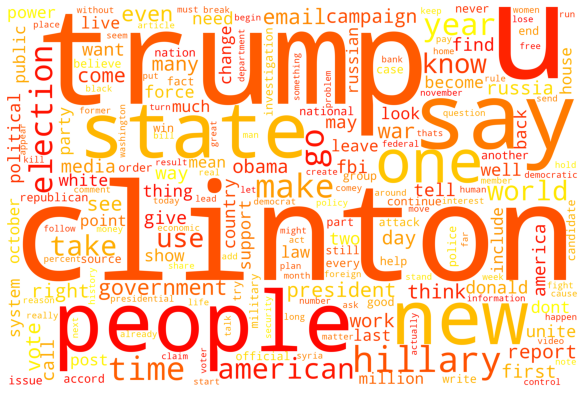

In [29]:
wordcloud_plot(text_fake_news, 'white', 'autumn_r')

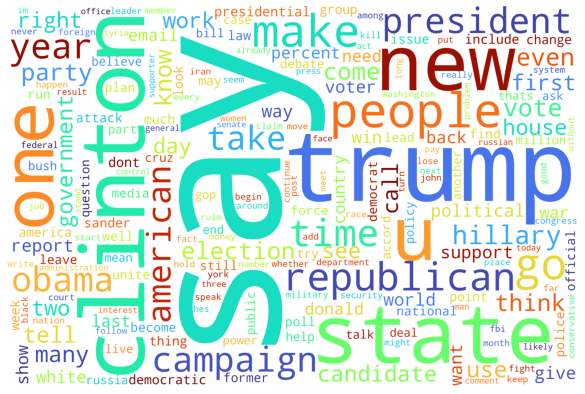

In [30]:
wordcloud_plot(all_text, 'white', 'turbo_r')

### Most frequent N-Grams

In [31]:
bigram_freq = nltk.FreqDist(nltk.bigrams(word_tokenize(all_text)))
bigram_freq.most_common(10)

[(('donald', 'trump'), 3962),
 (('hillary', 'clinton'), 3785),
 (('unite', 'state'), 3038),
 (('white', 'house'), 2405),
 (('new', 'york'), 2133),
 (('fox', 'news'), 1225),
 (('secretary', 'state'), 1162),
 (('trump', 'say'), 1046),
 (('supreme', 'court'), 1010),
 (('president', 'obama'), 998)]

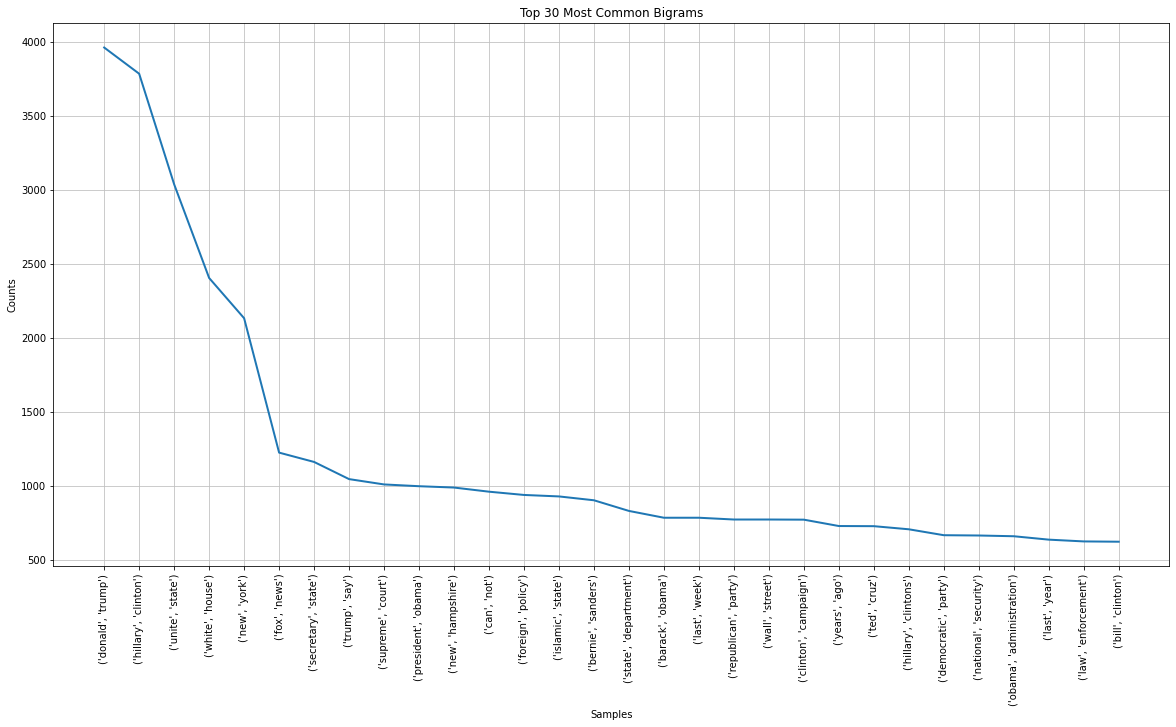

<AxesSubplot:title={'center':'Top 30 Most Common Bigrams'}, xlabel='Samples', ylabel='Counts'>

In [32]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=30)
bigram_freq.plot(30, cumulative=False,title='Top 30 Most Common Bigrams')

In [33]:
trigram_freq = nltk.FreqDist(nltk.trigrams(word_tokenize(all_text)))
trigram_freq.most_common(10)

[(('new', 'york', 'time'), 592),
 (('george', 'w', 'bush'), 463),
 (('president', 'barack', 'obama'), 317),
 (('former', 'secretary', 'state'), 273),
 (('president', 'unite', 'state'), 271),
 (('sen', 'ted', 'cruz'), 245),
 (('fbi', 'director', 'jam'), 206),
 (('tell', 'fox', 'news'), 201),
 (('sen', 'marco', 'rubio'), 199),
 (('sen', 'bernie', 'sanders'), 192)]

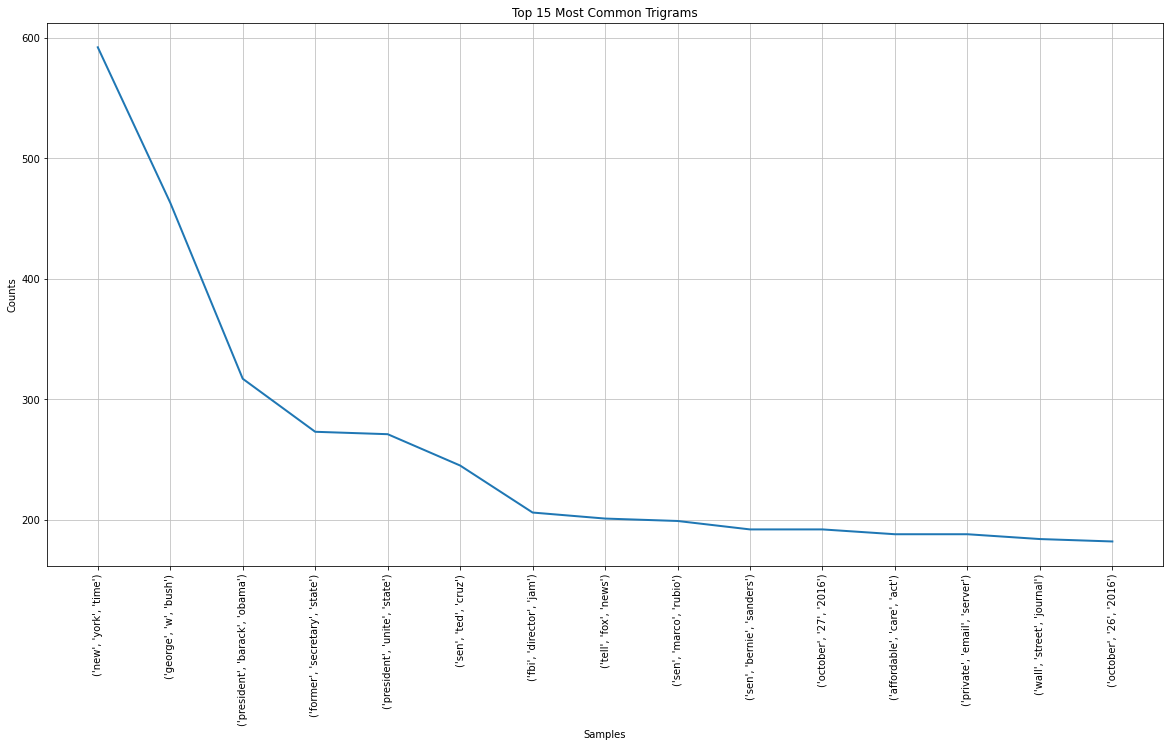

<AxesSubplot:title={'center':'Top 15 Most Common Trigrams'}, xlabel='Samples', ylabel='Counts'>

In [34]:
plt.figure(figsize=(20,10))
plt.xticks(rotation=30)
trigram_freq.plot(15, cumulative=False,title='Top 15 Most Common Trigrams')

## Named entity recognition


Using SpaceNet to identify named entities in the news.

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [36]:
nlp = spacy.load("en_core_web_sm")

### Example

In [37]:
doc = nlp(df['full_text'][3])

In [38]:
displacy.render(doc, style='ent')

### Top Entities

In [38]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

In [39]:
ent=df['full_text'].apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

<AxesSubplot:>

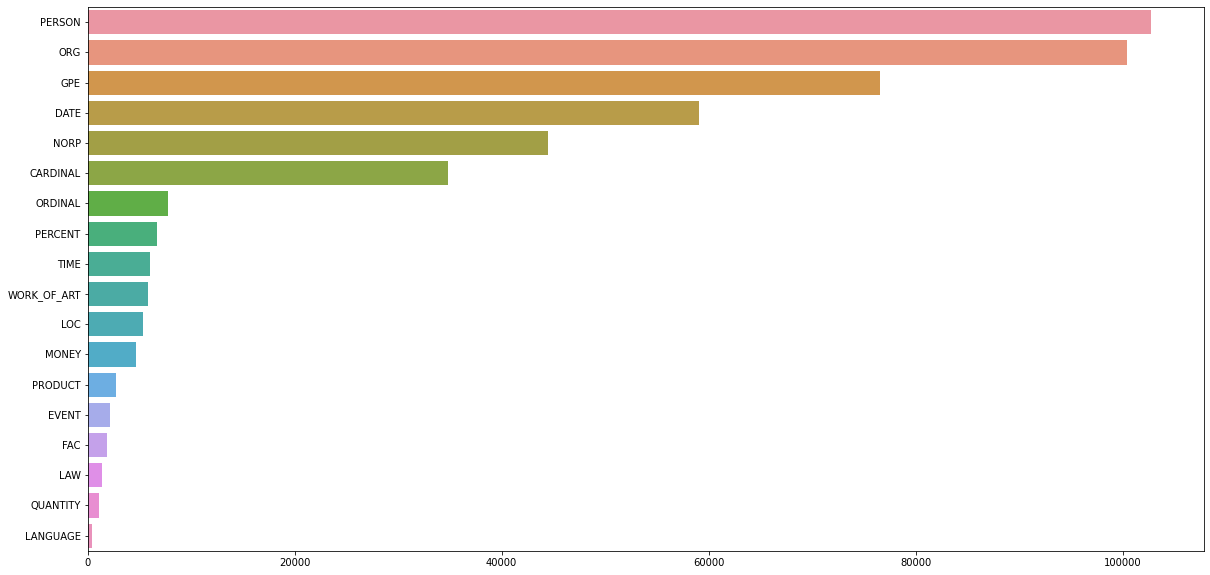

In [41]:
x,y=map(list,zip(*count))
plt.figure(figsize=(20,10))
sns.barplot(x=y,y=x)

### Most Frequent Tokens per Entity

In [41]:
def ner_entity(text,ent):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

#### Person

In [43]:
person=df['full_text'].apply(lambda x: ner_entity(x,"PERSON"))
person=[i for x in person for i in x]
counter=Counter(person)

C:\Users\atell\anaconda3\envs\NLP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

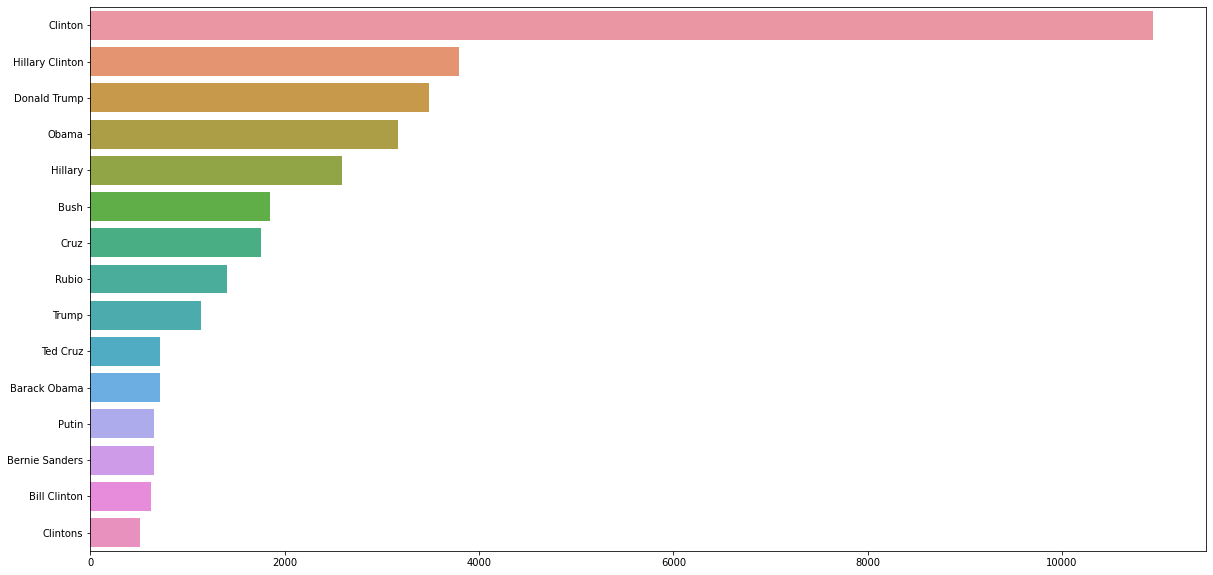

In [44]:
x,y=map(list,zip(*counter.most_common(15)))
plt.figure(figsize=(20,10))
sns.barplot(y,x)

#### ORG

In [82]:
org = df['full_text'].apply(lambda x: ner_entity(x,"ORG"))
org = [i for x in org for i in x]
counter = Counter(org)

C:\Users\atell\anaconda3\envs\NLP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

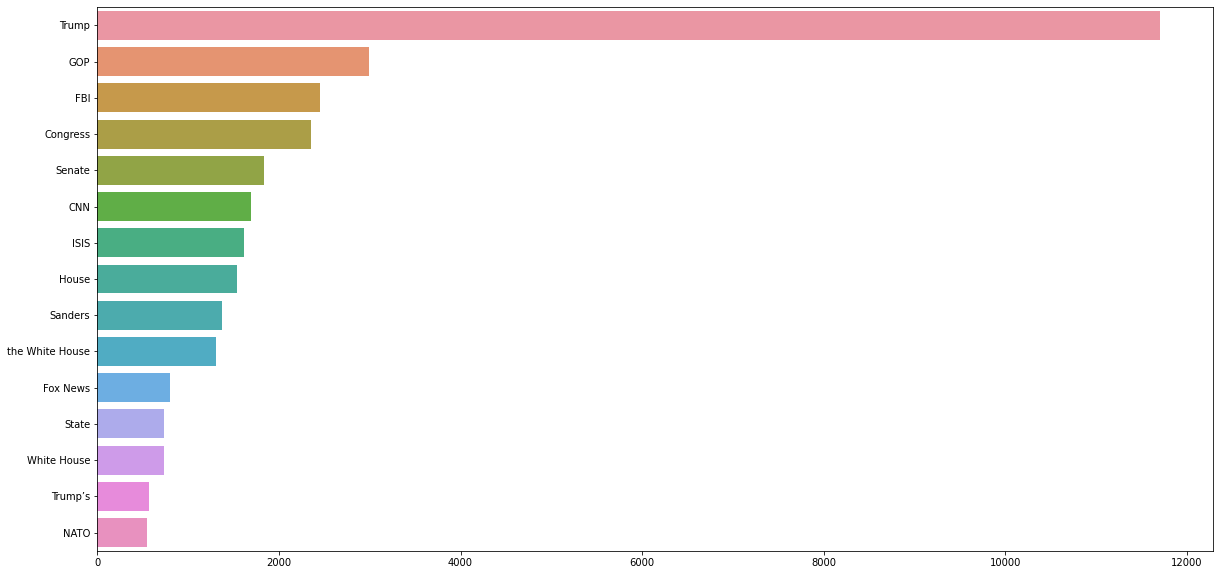

In [83]:
x,y=map(list,zip(*counter.most_common(15)))
plt.figure(figsize=(20,10))
sns.barplot(y,x)

#### GPE

In [84]:
gpe = df['full_text'].apply(lambda x: ner_entity(x,"GPE"))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

C:\Users\atell\anaconda3\envs\NLP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

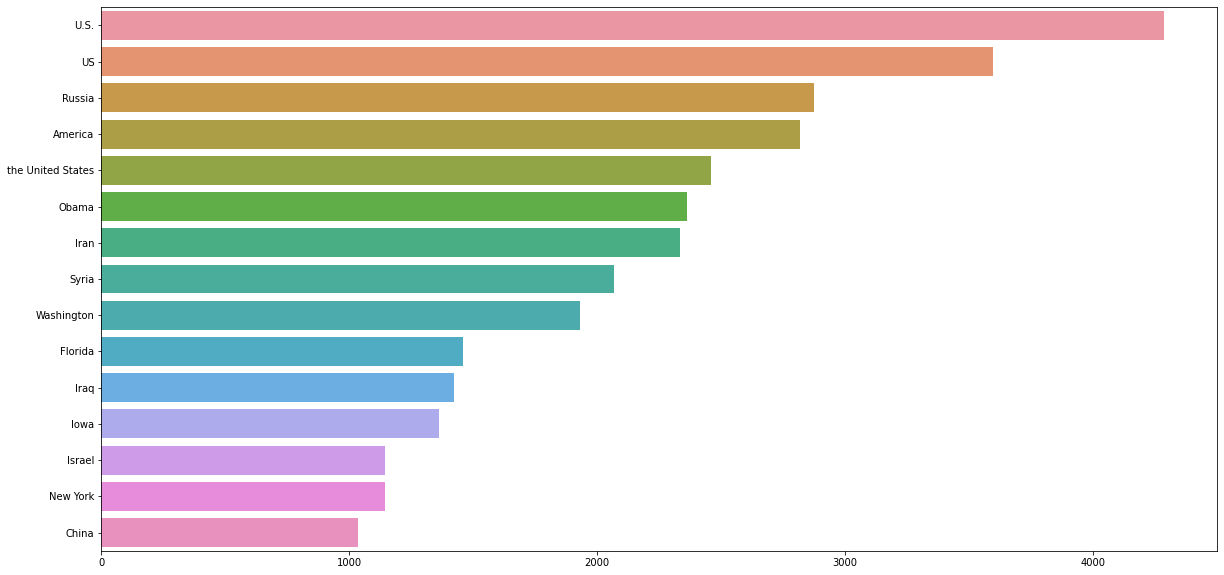

In [85]:
x,y=map(list,zip(*counter.most_common(15)))
plt.figure(figsize=(20,10))
sns.barplot(y,x)

#### Date

In [86]:
date = df['full_text'].apply(lambda x: ner_entity(x,"DATE"))
date = [i for x in date for i in x]
counter = Counter(date)

C:\Users\atell\anaconda3\envs\NLP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

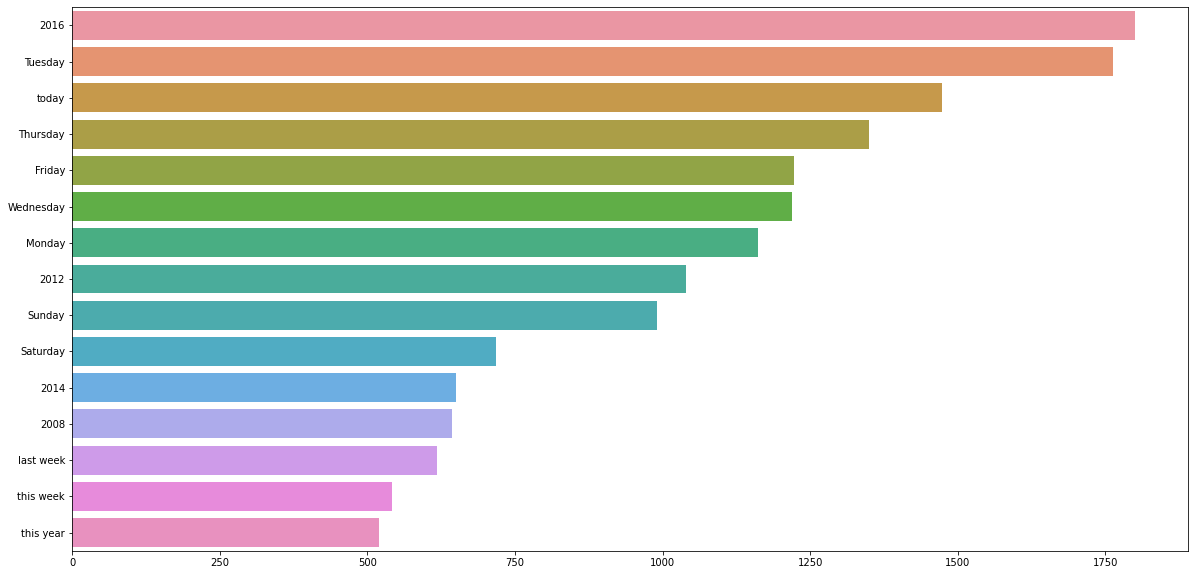

In [87]:
x,y=map(list,zip(*counter.most_common(15)))
plt.figure(figsize=(20,10))
sns.barplot(y,x)

#### NORP

In [42]:
norp = df['full_text'].apply(lambda x: ner_entity(x,"NORP"))
norp = [i for x in norp for i in x]
counter = Counter(norp)

C:\Users\tganto1\Anaconda3\envs\NLP\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

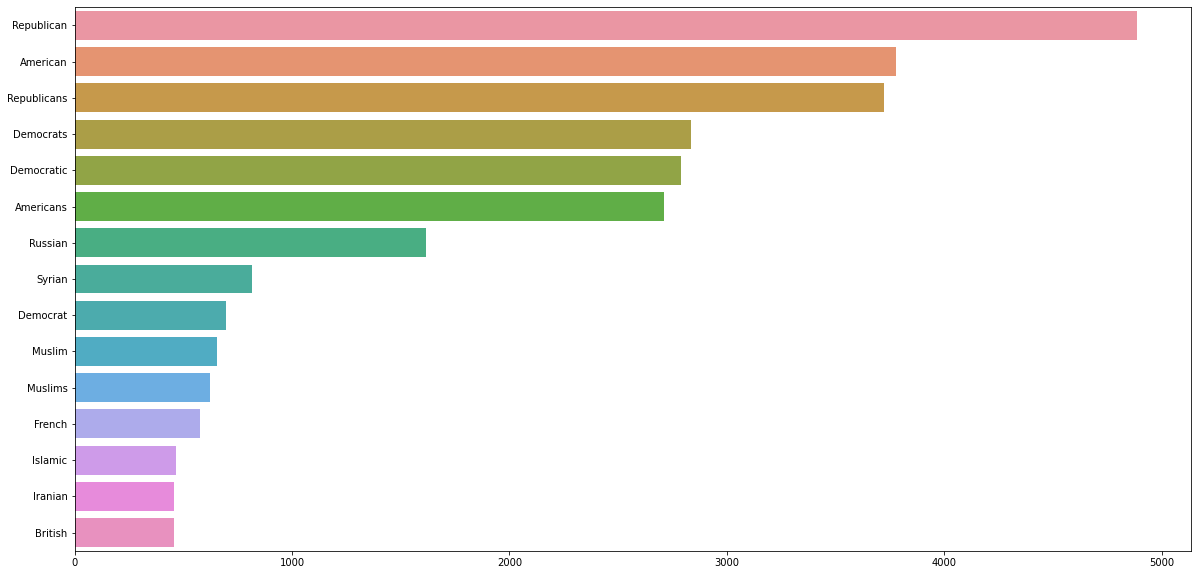

In [43]:
x,y=map(list,zip(*counter.most_common(15)))
plt.figure(figsize=(20,10))
sns.barplot(y,x)